# CS 4824 Final Project
**Author:** Eshan Kaul  
Team 29


## Motivation
* India is the **third largest** global consumer of energy in the world
* The motivation for this project is to **encourage** the use of renewable energy sources, such as solar energy, in order to increase sustainability and conserve foreign economic expenditures
* Solar power reduces greenhouse gas emissions and subsequently, the country’s dependence on fossil fuels
* Ultimately would like to **reduce India’s energy consumption** by predicting the exact amount of energy needed to be produced by Indian solar plants.

## Research Question
Can the Indian solar plant AC power production be accuratly forcasted in order to deliver the optimal energy-pricing strategy?

* By accurately predicting future solar power plant production, we may be able to optimize spending in order to encourage the use of renewable energy among Indian consumers (residential and commercial alike).
* Achieving this may have significant environmental benefits for not only South Asia, but the world.

## Data Introduction
All the data used in this notebook has been retrieved from Kaggle in the form of a comma separated value file. The data was gathered at **two solar power plants in India over a 34 day period in 15 minute intervals**. The source contains four data sets, however we analyzed two of the four: a plant generation data file and a plant weather sensor data file. The plant generation file is gathered at the inverter level: each inverter has multiple lines of solar panels attached to it (dim: 68778 rows × 7 columns). The sensor data is gathered at a plant level: single array of sensors optimally placed at the plant (dim: 3182 rows × 6 columns).

## Read In Data + EDA

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
# Read In Data
plant1_generation = pd.read_csv('Plant_1_Generation_Data.csv') 
plant1_weather = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Clean Data
plant1_weather_cleaned = plant1_weather.groupby('DATE_TIME')[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']].agg('sum').reset_index()
plant1_weather_cleaned['DATE_TIME'] = pd.to_datetime(plant1_weather_cleaned['DATE_TIME']) 
plant1_weather_cleaned['TIME'] = plant1_weather_cleaned['DATE_TIME'].dt.time 
plant1_weather_cleaned['DATE'] = pd.to_datetime(plant1_weather_cleaned['DATE_TIME'].dt.date)

# Merge Data
plant1_generation['DATE_TIME'] = pd.to_datetime(plant1_generation["DATE_TIME"])
plant1_weather['DATE_TIME'] = pd.to_datetime(plant1_weather["DATE_TIME"])
df = pd.merge(plant1_generation.drop(columns=['PLANT_ID']), plant1_weather.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

# Encode Variables
source_key_dict = {key: i for i, key in enumerate(df['SOURCE_KEY'].unique())}
df['SOURCE_KEY_NUMBER'] = df['SOURCE_KEY'].map(source_key_dict)
print(df.info())
X = df[['DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'IRRADIATION']]
y = df['AC_POWER']

df = df.iloc[40000:]


# Train Test Split
train_size = int(len(df) * 0.3)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45680 entries, 0 to 45679
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            45680 non-null  datetime64[ns]
 1   SOURCE_KEY           45680 non-null  object        
 2   DC_POWER             45680 non-null  float64       
 3   AC_POWER             45680 non-null  float64       
 4   DAILY_YIELD          45680 non-null  float64       
 5   TOTAL_YIELD          45680 non-null  float64       
 6   AMBIENT_TEMPERATURE  45680 non-null  float64       
 7   MODULE_TEMPERATURE   45680 non-null  float64       
 8   IRRADIATION          45680 non-null  float64       
 9   SOURCE_KEY_NUMBER    45680 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 3.8+ MB
None


In [3]:
X_train

DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  IRRADIATION
0             0.0    6259559.0            25.184316       0.0000
1             0.0    6183645.0            25.184316       0.0000
2             0.0    6987759.0            25.184316       0.0000
3             0.0    7602960.0            25.184316       0.0000
4             0.0    7158964.0            25.184316       0.0000
...           ...          ...                  ...          ...
1699       6418.0    7184410.0            23.787237       0.0001
1700       6375.0    7175477.0            23.787237       0.0001
1701       6373.0    7117866.0            23.787237       0.0001
1702       6350.0    7023182.0            23.787237       0.0001
1703       6387.0    7045068.0            23.787237       0.0001

[1704 rows x 4 columns]

In [4]:
df

DATE_TIME       SOURCE_KEY     DC_POWER    AC_POWER  \
40000 2020-06-15 06:45:00  wCURE6d3bPkepu2  1471.000000  143.575000   
40001 2020-06-15 06:45:00  z9Y9gH1T5YWrNuG  1475.500000  144.025000   
40002 2020-06-15 06:45:00  zBIq5rxdHJRwDNY  1445.250000  141.087500   
40003 2020-06-15 06:45:00  zVJPv84UY57bAof  1470.857143  143.628571   
40004 2020-06-15 07:00:00  1BY6WEcLGh8j5v7  1940.714286  190.257143   
...                   ...              ...          ...         ...   
45675 2020-06-17 23:45:00  uHbuxQJl8lW7ozc     0.000000    0.000000   
45676 2020-06-17 23:45:00  wCURE6d3bPkepu2     0.000000    0.000000   
45677 2020-06-17 23:45:00  z9Y9gH1T5YWrNuG     0.000000    0.000000   
45678 2020-06-17 23:45:00  zBIq5rxdHJRwDNY     0.000000    0.000000   
45679 2020-06-17 23:45:00  zVJPv84UY57bAof     0.000000    0.000000   

       DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
40000    53.875000  7009751.875            22.312394           24.034580   
40001    53.375000  7232521.375            22.312394           24.034580   
40002    52.375000  6565189.375            22.312394           24.034580   
40003    53.428571  7344333.429            22.312394           24.034580   
40004    89.428571  6467764.429            22.742930           25.804112   
...            ...          ...                  ...                 ...   
45675  5967.000000  7287002.000            21.909288           20.427972   
45676  5147.625000  7028601.000            21.909288           20.427972   
45677  5819.000000  7251204.000            21.909288           20.427972   
45678  5817.000000  6583369.000            21.909288           20.427972   
45679  5910.000000  7363272.000            21.909288           20.427972   

       IRRADIATION  SOURCE_KEY_NUMBER  
40000     0.102704                 17  
40001     0.102704                 18  
40002     0.102704                 19  
40003     0.102704                 20  
40004     0.155734                  0  
...            ...                ...  
45675     0.000000                 16  
45676     0.000000                 17  
45677     0.000000                 18  
45678     0.000000                 19  
45679     0.000000                 20  

[5680 rows x 10 columns]

In [5]:
pd.plotting.scatter_matrix(df, figsize=(15,15))
plt.show()

In [6]:
#Plant 1 generation data
plant1_daily = plant1_generation.groupby('DATE_TIME')[['DC_POWER','AC_POWER', 'DAILY_YIELD','TOTAL_YIELD']].agg('sum').reset_index()
plant1_daily['DATE_TIME'] = pd.to_datetime(plant1_daily['DATE_TIME']) 
plant1_daily['TIME'] = plant1_daily['DATE_TIME'].dt.time 
plant1_daily['DATE'] = pd.to_datetime(plant1_daily['DATE_TIME'].dt.date)
fig = px.scatter(plant1_daily, x="TIME", y="AC_POWER", marginal_x="histogram")
fig.show()

### Correlation
Definition: Any statistical relationship, whether causal or not, between two random variables or bivariate data. The Correlation Coefficient or Pearson correlation coefficient is commonly obtained by taking the ratio of the covariance of the two variables in question from the numerical dataset, normalized to the square root of their variances. Mathematically, it is the division of the covariance (joint variability of two random variables) of the two variables by the product of their standard deviations.

$$ \rho X,Y = \text{corr(X,Y)} = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}  = \frac{E[(X-{\mu}x)(Y-{\mu}y)]}{\sigma_x \sigma_y}$$


$$ \text{cov}(X, Y) = E[(X - E[X])(Y - E[Y])]$$

In [7]:
plt.figure(figsize=(15, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


# Decision Tree Regressor

The Decision Tree Regressor is a tree-based machine learning model that aims to predict continuous target values based on input features. It recursively divides the input space into non-overlapping regions, and each region is assigned an average target value calculated from the training data. The tree is constructed by selecting the best feature and threshold at each node to minimize the mean squared error (MSE) of the target values.

## Algorithm

1. **Initialization**: Start with the entire dataset at the root node.
2. **Node splitting**: At each node, iterate through all features and potential thresholds to find the best feature and threshold that minimizes the MSE.
3. **Recursion**: Recursively split the dataset into two subsets based on the best feature and threshold found in step 2, and create the left and right child nodes.
4. **Stopping criteria**: Stop splitting if any of the following conditions is met:
   - The maximum depth of the tree is reached.
   - The number of samples in the node is less than the minimum samples required to split.
5. **Prediction**: Assign the mean target value of the samples in a node as the prediction value for that node (leaf node).

## Mean Squared Error (MSE)

The MSE is used as a splitting criterion to minimize the impurity in the child nodes. It is calculated as follows:

MSE = $\frac{1}{n} \sum{(y_i - y_{\text{mean}})^2}$

where $n$ is the number of samples in a node, $y_i$ is the target value of the i-th sample, and $y_{\text{mean}}$ is the mean target value of all samples in the node.

The best feature and threshold to split a node are selected by minimizing the weighted sum of the MSEs in the left and right child nodes.

## Benefits

- Decision trees are easy to interpret and visualize.
- They can handle both continuous and categorical input features.
- Decision tree models require little preprocessing, such as normalization or scaling.

## Limitations

- Decision trees are prone to overfitting, especially when they are deep.
- They are sensitive to small changes in the training data, which can lead to different tree structures.
- Decision tree models can be biased towards features with many levels.

In [8]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth  # Maximum depth of the tree
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split a node
        
        # Properties for the current node
        self.feature_idx = None  # Index of the feature used for splitting
        self.threshold = None  # Threshold value used for splitting
        self.left = None  # Left subtree
        self.right = None  # Right subtree
        self.value = None  # Value of the leaf node

    # Fit the decision tree model
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Set the maximum depth to infinity if not provided
        if self.max_depth is None:
            self.max_depth = np.inf

        # Convert the min_samples_split to an integer if given as a fraction
        if self.min_samples_split <= 1:
            self.min_samples_split = int(self.min_samples_split * n_samples)
        else:
            self.min_samples_split = int(self.min_samples_split)

        # Check if the current node should be split
        if n_samples >= self.min_samples_split and self.max_depth > 0:
            # Variables to store the best feature and threshold for splitting
            best_feature = None
            best_threshold = None
            best_loss = np.inf

            # Iterate over each feature
            for feature_idx in range(n_features):
                # Get unique thresholds for the current feature
                thresholds = np.unique(X[:, feature_idx])

                # Iterate over each threshold
                for threshold in thresholds:
                    # Split the data based on the current threshold
                    y_left = y[X[:, feature_idx] < threshold]
                    y_right = y[X[:, feature_idx] >= threshold]

                    # Calculate the loss for the current split
                    if len(y_left) > 0 and len(y_right) > 0:
                        loss = self._mse(y_left) + self._mse(y_right)

                        # Update the best split if the current split has a lower loss
                        if loss < best_loss:
                            best_feature = feature_idx
                            best_threshold = threshold
                            best_loss = loss

            # If a valid split is found, create the left and right subtrees
            if best_feature is not None:
                self.feature_idx = best_feature
                self.threshold = best_threshold

                # Recursively build left and right subtrees
                left_idx = X[:, best_feature] < best_threshold
                right_idx = X[:, best_feature] >= best_threshold

                self.left = DecisionTreeRegressor(max_depth=self.max_depth-1, min_samples_split=self.min_samples_split)
                self.left.fit(X[left_idx], y[left_idx])

                self.right = DecisionTreeRegressor(max_depth=self.max_depth-1, min_samples_split=self.min_samples_split)
                self.right.fit(X[right_idx], y[right_idx])

        # Compute the leaf value as the mean of the target values
        self.value = np.mean(y)

        return self

    # Predict the target variable for given input features
    def predict(self, X):
        # Check if the current node is a leaf node or an internal node
        if self.feature_idx is not None and self.threshold is not None:
            # Split the input data based on the feature index and threshold
            mask = X[:, self.feature_idx] < self.threshold
            y_pred = np.zeros(X.shape[0])
            y_pred[mask] = self.left.predict(X[mask])
            y_pred[~mask] = self.right.predict(X[~mask])
        else:
            y_pred = np.full(X.shape[0], self.value)
        
        return y_pred
    
    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)
    
    def plot_predictions_vs_actual(self, y_true, y_pred):
        plt.figure(figsize=(10, 5))

        # Sort values and predictions along the x-axis
        sorted_indices = np.argsort(y_true)
        y_true_sorted = y_true[sorted_indices]
        y_pred_sorted = y_pred[sorted_indices]

        # Plot actual values as a scatter plot
        plt.scatter(range(len(y_true_sorted)), y_true_sorted, label="Actual Values", edgecolors='k', alpha=0.7)

        # Plot predicted values as a line
        #plt.plot(y_pred_sorted, label="Predicted Values", linestyle='--', linewidth=2)
        plt.scatter(range(len(y_pred_sorted)), y_pred_sorted, label="Predicted Values", edgecolors='r', alpha=0.7)

        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.title("Predictions vs. Actual Values")
        plt.legend()

        plt.show()

In [9]:
X = X_train.to_numpy()
y = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [10]:
decision_tree = DecisionTreeRegressor(max_depth=None, min_samples_split=2)
decision_tree.fit(X, y)
y_pred = decision_tree.predict(X_test)

# decision_tree.plot_predictions_vs_actual(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R^2 score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

R^2 score: 0.9453311692516064
MSE: 8780.511186210757
RMSE: 93.70438189439572


# Gradient Boosting Regressor

Gradient Boosting Regressor is an ensemble learning technique that builds a strong model by combining the predictions of multiple weak models, typically decision trees. It works by iteratively fitting decision trees to the residual errors of the previous model, thereby minimizing the overall loss.

## Algorithm

1. **Initialize**: Calculate the bias term as the mean of the target variable, and initialize the predictions with this bias term.
2. **Boosting rounds**: Perform a given number of boosting rounds (n_estimators), where each round consists of the following steps:
   - Calculate the residuals between the target values and the current predictions.
   - Train a decision tree regressor on the residuals, using a specified maximum depth and minimum number of samples required to split a node.
   - Update the predictions by adding the weighted predictions of the trained decision tree, scaled by a learning rate (shrinkage parameter).
3. **Prediction**: Predict the target values for given input features by summing the bias term and the weighted predictions from each decision tree.

## Learning Rate

The learning rate, or shrinkage parameter, is a positive scalar that scales the contribution of each decision tree to the overall model. A smaller learning rate results in a more conservative model, reducing the risk of overfitting, but may require more boosting rounds to achieve optimal performance.

## Benefits

- Gradient Boosting Regressor can model complex nonlinear relationships between input and output variables.
- It can handle noisy and high-dimensional data, as well as data with missing values.
- Gradient Boosting Regressor generally performs well on a wide range of problems, often outperforming other techniques.

## Limitations

- Gradient Boosting Regressor can be sensitive to the choice of hyperparameters, such as the number of boosting rounds, learning rate, and tree depth.
- It can be computationally expensive and time-consuming to train, especially for large datasets and a high number of boosting rounds.
- The interpretation of the results is not as straightforward as in simpler models, such as linear regression.

In [11]:
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2):
        self.n_estimators = n_estimators  # Number of boosting rounds (trees)
        self.learning_rate = learning_rate  # Learning rate (shrinkage)
        self.max_depth = max_depth  # Maximum depth of the individual decision trees
        self.min_samples_split = min_samples_split  # Minimum number of samples required to split a node
        
        self.estimators = []  # List to store the decision tree estimators
        self.bias = None  # Bias term (mean of the target variable)

    # Fit the gradient boosting model
    def fit(self, X, y):
        self.bias = np.mean(y)  # Calculate the bias term
        y_pred = np.full_like(y, self.bias)  # Initialize the predictions with the bias term
        
        # Perform boosting rounds
        for i in range(self.n_estimators):
            residuals = y - y_pred  # Calculate the residuals
            
            # Train a decision tree regressor on the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X, residuals)
            
            self.estimators.append(tree)  # Add the trained tree to the list of estimators
            
            # Update the predictions by adding the weighted tree predictions
            y_pred += self.learning_rate * tree.predict(X)
        
        return self

    # Predict the target variable for given input features
    def predict(self, X):
        y_pred = np.full(X.shape[0], self.bias)  # Initialize the predictions with the bias term
        
        # Add the weighted predictions from each tree
        for tree in self.estimators:
            y_pred += self.learning_rate * tree.predict(X)
        
        return y_pred


In [12]:
gradient_boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, min_samples_split=2)
gradient_boosting.fit(X, y)
y_pred = gradient_boosting.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R^2 score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

R^2 score: 0.8136697715417036
MSE: 29927.0101977689
RMSE: 172.99424903091113


# Kernel Partial Least Squares (KPLS) Regression

Kernel Partial Least Squares (KPLS) Regression is an extension of the Partial Least Squares (PLS) Regression that utilizes kernel functions to model complex nonlinear relationships between input and output variables. It combines the feature extraction abilities of kernel methods, such as the Support Vector Machine (SVM), with the dimensionality reduction and regression capabilities of PLS.

## Algorithm

1. **Kernel matrix**: Compute the kernel matrix K using a chosen kernel function (e.g., RBF kernel) that maps the input features to a higher-dimensional space.
2. **Centering**: Center the kernel matrix K and target values Y.
3. **Iterative decomposition**: For a given number of components, iteratively extract the latent variables (scores) T and U, and the weight vectors P.
   - Initialize U as the centered target values Y.
   - Compute the score vector T as the product of the centered kernel matrix K and U, and normalize T.
   - Compute the weight vector P as the product of the centered kernel matrix K and T, and normalize P.
   - Update the centered kernel matrix K by subtracting the outer product of T and T times K.
4. **Regression**: Calculate the regression coefficients W by solving the linear system T * W = Y.
5. **Prediction**: Predict the target values Y_pred using the product of the scores T and the regression coefficients W.

## Radial Basis Function (RBF) Kernel

The RBF kernel is a popular choice for nonlinear kernel methods because of its flexibility and smoothness. It is defined as:

$K(x, x') = exp(-γ ||x - x'||^2)$

where x and x' are two input feature vectors, and γ is a positive parameter that controls the shape of the kernel. A larger γ results in a more flexible, localized model, while a smaller γ leads to a smoother, more global model.

## Benefits

- KPLS can model complex nonlinear relationships between input and output variables.
- It combines the advantages of kernel methods with the dimensionality reduction and regression capabilities of PLS.
- KPLS can handle collinear and noisy input features.

## Limitations

- KPLS requires the selection of a suitable kernel function and its parameters.
- It can be computationally expensive for large datasets due to the need to compute and store the kernel matrix.
- The interpretation of the results is not as straightforward as in linear PLS.

In [13]:
# Radial basis function (RBF) kernel
def rbf_kernel(X, gamma=None):
    # If gamma is not provided, set it to the default value: 1.0 / number of features
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    # Compute the pairwise Euclidean distances between input feature vectors
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    
    # Calculate the RBF kernel matrix using the provided gamma parameter
    K = np.exp(-gamma * pairwise_dists ** 2)
    
    return K

# Kernel Partial Least Squares (PLS) algorithm
def kernel_pls(X, Y, n_components, kernel=rbf_kernel, gamma=None, center=True):
    # Compute the kernel matrix using the provided kernel function (RBF by default)
    N = X.shape[0]
    K = kernel(X, gamma=gamma)
    
    # Center the kernel matrix, if specified
    if center:
        I = np.eye(N)
        H = I - (1.0 / N) * np.ones((N, N))
        K_centered = H @ K @ H
    else:
        K_centered = K

    # Initialize matrices for the latent variables (scores) and weight vectors
    Y = Y.reshape(-1, 1)
    T = np.zeros((N, n_components))
    U = np.zeros((N, n_components))
    P = np.zeros((N, n_components))
    
    # Iteratively calculate T, U, and P matrices
    for i in range(n_components):
        u = Y
        t = K_centered @ u
        t /= np.linalg.norm(t)
        
        p = K_centered.T @ t
        p /= np.linalg.norm(p)

        K_centered = K_centered - np.outer(t, t.T @ K_centered)
        T[:, i] = t.ravel()
        U[:, i] = u.ravel()
        P[:, i] = p.ravel()
    
    # Perform regression using the pseudoinverse of T and Y
    W = np.linalg.pinv(T) @ Y
    
    # Calculate predictions using the scores T and the regression coefficients W
    Y_pred = T @ W
    
    return T, U, P, Y_pred

# Function to plot X and Y scores
def plot_scores(T, U):
    # Create a figure with two subplots for X and Y scores
    plt.figure(figsize=(10, 5))
    
    # Plot X scores (T)
    plt.subplot(1, 2, 1)
    plt.scatter(T[:, 0], T[:, 1], c='blue', edgecolors='k', label='X scores')
    plt.xlabel('T[0]')
    plt.ylabel('T[1]')
    plt.title('X scores')
    
    # Plot Y scores (U)
    plt.subplot(1, 2, 2)
    plt.scatter(U[:, 0], U[:, 1], c='red', edgecolors='k', label='Y scores')
    plt.xlabel('U[0]')
    plt.ylabel('U[1]')
    plt.title('Y scores')

    # Display the plots
    plt.show()

R-squared: 0.8920075470470994
RMSE: 0.3286220518359969


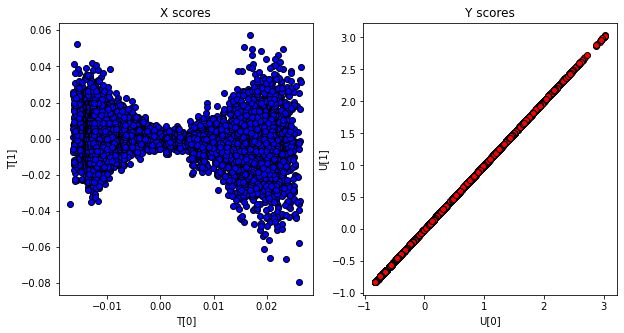

In [14]:
# KPLS Example 

X = df.drop(columns=['DATE_TIME', 'SOURCE_KEY', 'AC_POWER'])
X['DATE_TIME_numeric'] = pd.to_datetime(df['DATE_TIME']).view(int) / 10**9

Y = df['AC_POWER'].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

n_components = 2
T, U, P, Y_pred = kernel_pls(X_scaled, Y_scaled, n_components)

# Calculate performance metrics
r2 = r2_score(Y_scaled, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_scaled, Y_pred))
print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')

# Plot the scores
plot_scores(T, U)